# A simple Gaussian example

By Kyle Cranmer, Lukas Heinrich, Tim Head, Gilles Louppe
(*Based on earlier work with NYU CDS masters students Manoj Kumar, Phil Yeres, and Michele Ceru and discussions with Brenden Lake and Gilles Louppe.*)

The point of this notebook is to explore the synergy of three powerful techniques:

   1. generic likelihood-free inference engines (eg. ABC, carl, etc.) that enable statistical inference on the parameters of a theory that are implicitly defined by a simulator
 
   2. workflows that encapsulate scientific pipelines and extend the scope from reproducibility to reusability
 
   1. active learning and sequential design algorithms (eg. Bayesian optimization) that balance exploration and exploitation to efficiently optimize an expensive black box objective function
 
Together, these three ideas can be combined to enable an efficient and automated loop of the scientific method -- at least, for a sufficiently well posed problem. The scientist's input to the system are:

 * an external workflow that implements some experimental protocol (orange **Exp** component)
 * an external workflow that implements a simulator for those experiments, which depends on some theoretical parameters that we would like to infer (orange **Sim** component).
 
Interesingly, we will use the simulator not only to perform inference on the parameters, but also to design the next experiment (this is where active learning comes in).

Notation:

   * $\phi$ : Parameters that specify the experimental configuration

   * $\theta$: Parameters of the theory / simulator, which we would like to infer from the experimental data

   * $X$ : Data generated from the experiment or simulator

<img src="flowchart.png" alt="flowchart" width="80%" />

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib nbagg

In [2]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/cranmer/active_sciencing/yadage/yadage"
    }
});

<IPython.core.display.Javascript object>

In [3]:
import distr
import common
import plots

In [4]:
import models.model_gaussian as model

## The simulator

In this simple example, the simulator will produce data according to the following model.
The experiments are most senstive when $phi=\pi$.

\begin{equation}
x \sim G(\theta, 2+cos(\phi)
\end{equation}

## Step 1: Perform Experiment

User provides workflow that implements the real experiments (orange component of flowchart labeled **Exp**).

In [5]:
science_ndata = 20
science_theta_nature = 1.0

In [6]:
def collect_data(phi,ndata, widget = None):
    return model.simulator(science_theta_nature,phi,ndata, widget, delay = True)

## Step 2: Bayesian Update

We Here we use a generic simulation-based inference engine like ABC or Carl to update from prior to posterior. The user provides a workflow that implements the simulator (orange component of the flowchart labled **Sim**) and we infer the posterior probability of the parameters of the simulator given the data.

In [7]:
def calculate_posterior(prior,data,phi):
    posterior = common.calculate_posterior(
                            prior,data,phi,
                            lnprob_args = model.details_likelihood_settings,
                            n_chainlen = 50
    )
    maximum_a_post = posterior.map(model.details_map_bins)

    print 'Best Theta: ', maximum_a_post
    return posterior, maximum_a_post

## Step 3: Optimize Experimental Configuration

Based on the updated posterior $p(\theta)$ we will consider future experiments with configuration $\phi$. For each of those configurations, we will run several simulations of the experiment and perform inference on those simulated datasets to estimate the expected information gain (EIG)

\begin{equation}
EIG(\phi) =  \int dx d\theta \; p(x | \theta) p(\theta) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ] \approx \int dx  \; p(x | \theta_{MAP}) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ]
\end{equation}
where
\begin{equation}
H\left [P(\theta) \right] = \int P(\theta) \log P(\theta) d\theta 
\end{equation}

To efficiently optimize $EIG[\phi]$ we will use an active learning procedure like [Bayesian Optimization](https://scikit-optimize.github.io).


In [13]:
def design_next_experiment(prior, ax = None, fig = None, widget = None):
    eig_settings = common.eig_search_settings(model,science_ndata, widget.children[0])
    
    res_gp   = common.design_next_experiment_bayesopt(
                    prior,model.phi_range,eig_settings,
                    n_random_calls = 2,n_totalcalls = 10,
                    ax = ax, fig = fig, widget = widget.children[1]
                )
    res_next_phi = res_gp[0].x[0]
    
    print 'Next Phi: ', res_next_phi
    return res_gp,res_next_phi

In [14]:
widgets, subwidgets = common.overview_widgets(model)
widgets

<IPython.core.display.Javascript object>


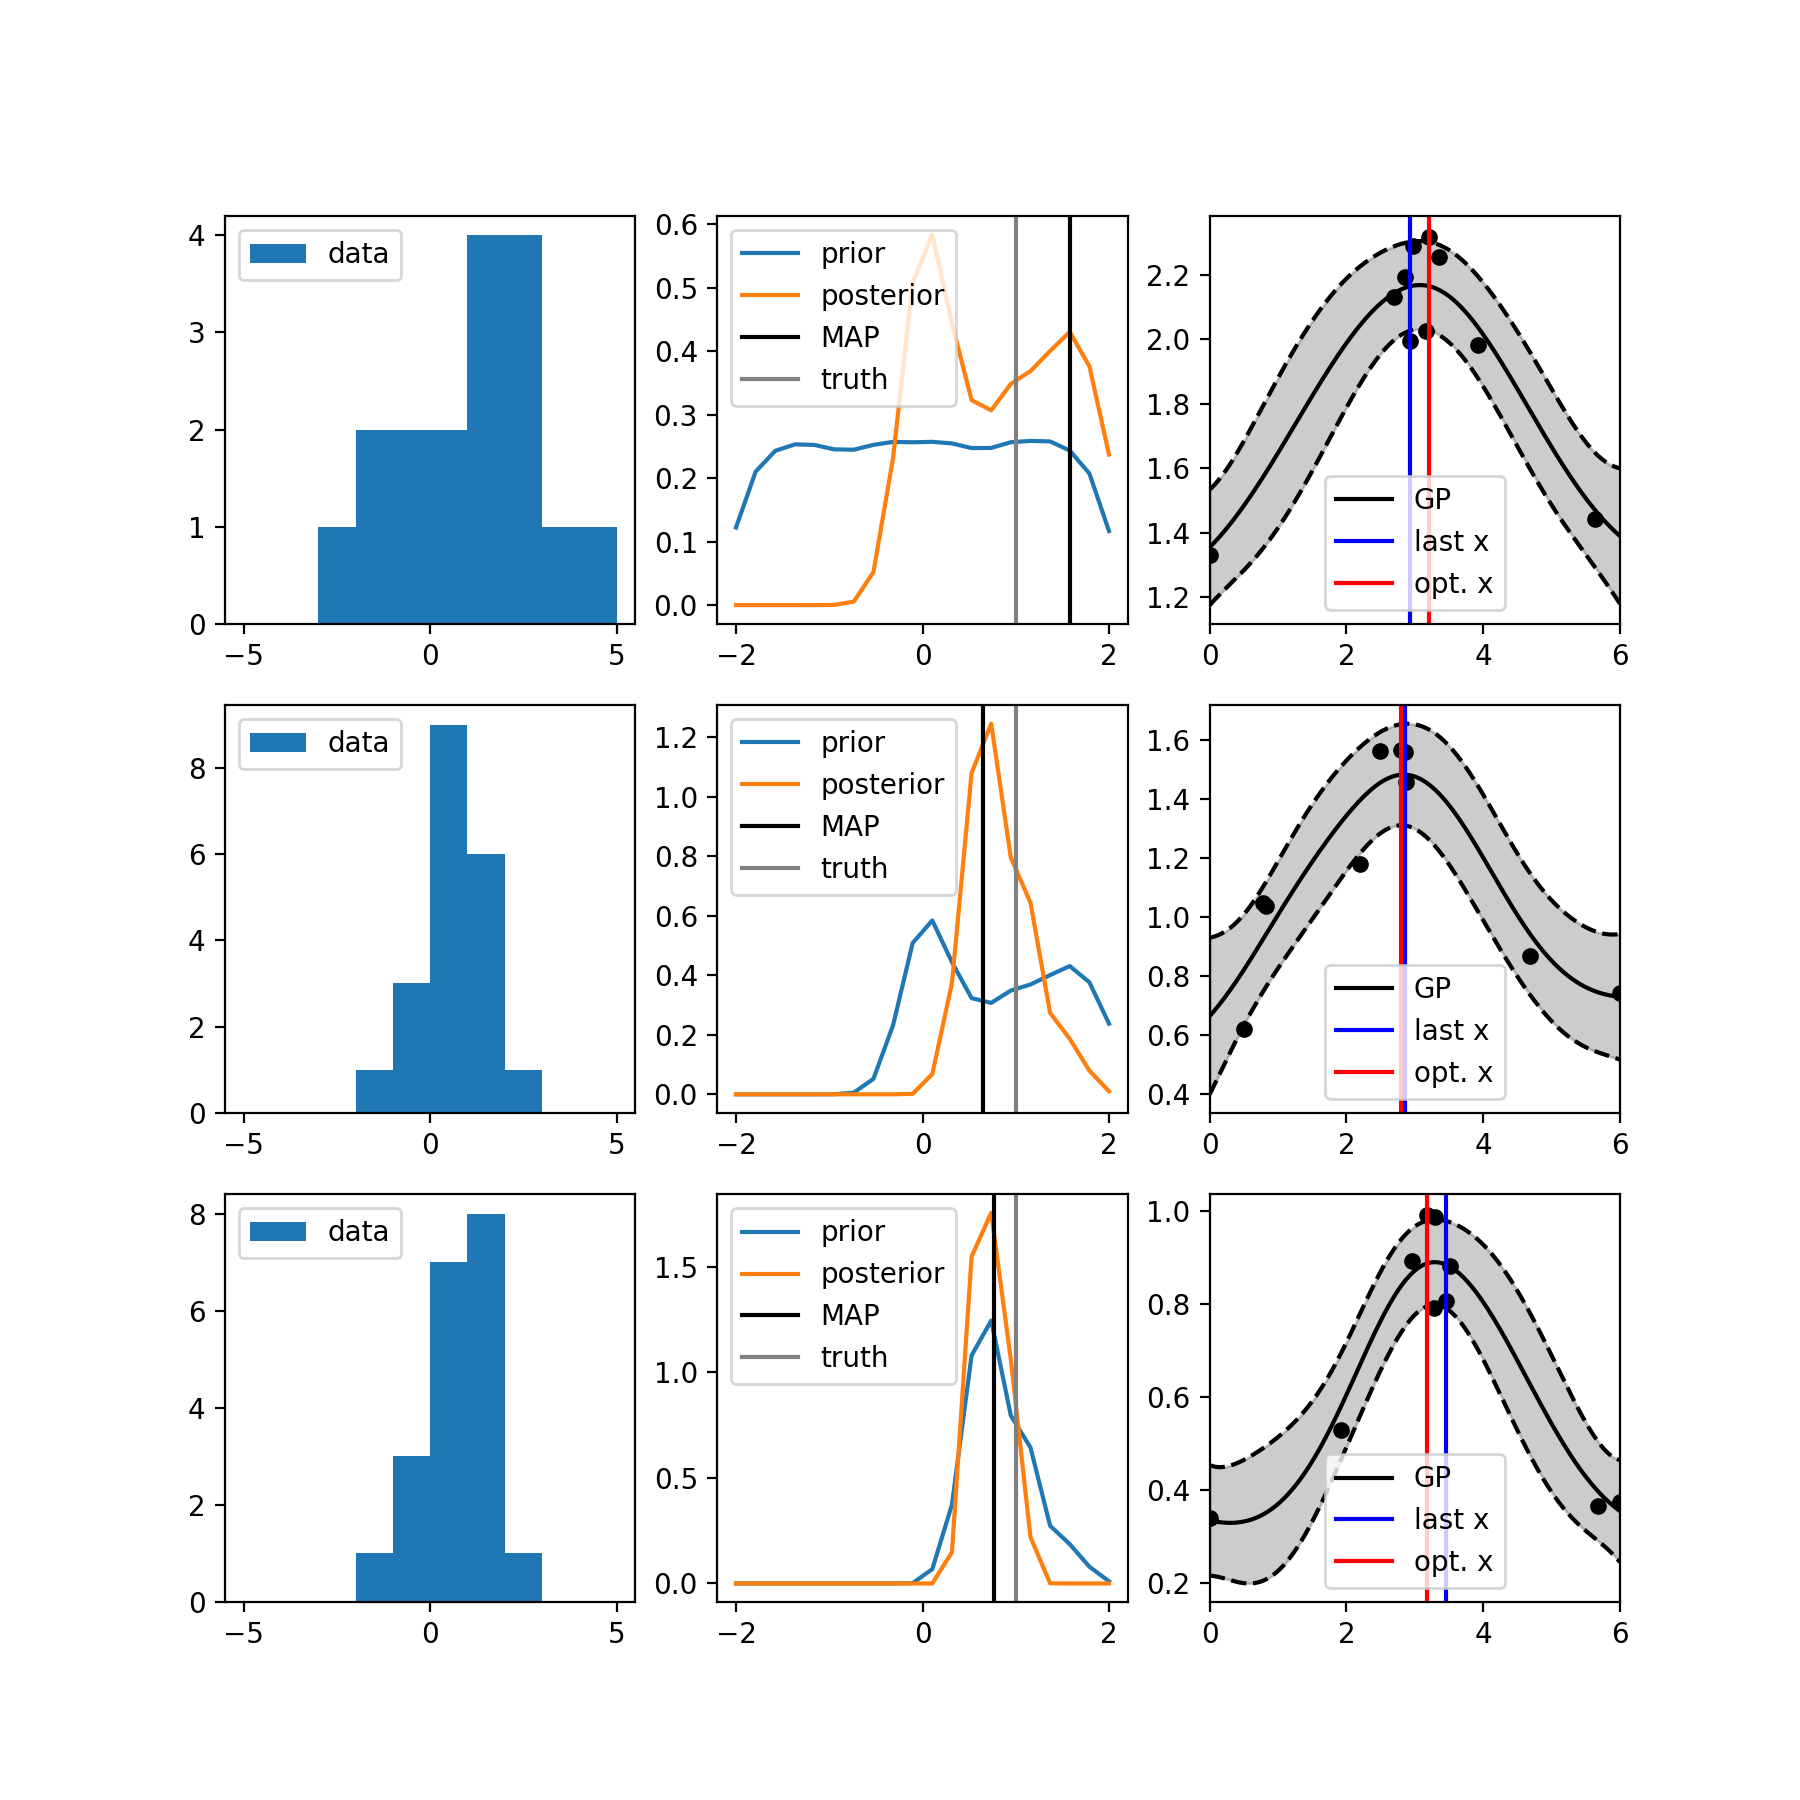

In [15]:
n_science_iterations = 3
fig,axarr = plt.subplots(n_science_iterations,3)
fig.set_size_inches(9,3*n_science_iterations)

# Running the Science Loop

In [16]:
# initial experimental settings and uninformative prior
loop_phi = -1
loop_prior = distr.Distribution('prior',range = model.theta_range)

In [17]:
science_history = []
for i in range(n_science_iterations):
        ## 1. Perform Experiment
    subwidgets[0].toggle(0)
    loop_data = collect_data(loop_phi,science_ndata, widget = subwidgets[1])
    plots.plot_data(loop_data,model.data_range, ax = axarr[i][0])
    fig.canvas.draw()

    ## 2. Calculate the Posterior
    subwidgets[0].toggle(1)
    loop_posterior, loop_best_theta = calculate_posterior(loop_prior,loop_data,loop_phi)
    plots.plot_posterior(loop_prior,loop_posterior,loop_best_theta,science_theta_nature, model.theta_range, ax = axarr[i][1])
    fig.canvas.draw()

    ## 3. Design Next Experiment
    subwidgets[0].toggle(2)
    loop_res_gp, loop_next_phi = design_next_experiment(loop_posterior,ax = axarr[i][2], fig = fig, widget = subwidgets[2])

    science_history.append([loop_data,loop_prior,loop_posterior,loop_best_theta,science_theta_nature,loop_res_gp])
    
    ## 5. Update our Prior and experimental settings
    loop_prior = loop_posterior
    loop_phi   = loop_next_phi
    time.sleep(5) # appreciate plots!

Best Theta:  1.57841127978
2017-06-10 07:12:13.289310 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 3.20343792942
2017-06-10 07:12:17.807979 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 5.64090440293
2017-06-10 07:12:22.279188 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 2.69635081355
2017-06-10 07:12:26.584865 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 0.0
2017-06-10 07:12:30.864821 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 3.35259020855
2017-06-10 07:12:35.061912 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 3.92112632992
2017-06-10 07:12:39.403368 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 3.15778815263
2017-06-10 07:12:43.744693 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 2.97029709186
2017-06-10 07:12:48.014547 EIG via 4 parallel experiments with [theta,phi] 1.57841127978 2.85204769409
2017-06-10 07:12:52.163420 EIG via 4 parallel experiment

## Conclusion

We've run the active science loop a few times and the system has found nearly optimal experimental settings and the prior has been updated concentrated near the (unknown) true value for the parameter.

## Fin.